In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
plt.style.use(plt.style.available[-2])
plt.rcParams['savefig.dpi'] = 150

In [3]:
speed_of_light = 299792458.

def mm_to_fs(mm):
    t = (mm * 0.001 / speed_of_light)* 1e15
    return t

In [4]:
mm_to_fs(300)/1e6

1.0006922855944562

In [5]:
speed_of_light = 299792458.0
HeNe_period_m = 632.816e-9
HeNe_period_fs = 632.816e-9 / speed_of_light * 1e15
shots_per_period = 2
laser_freq_kHz = 2
dist_mm = HeNe_period_m * 1000. / shots_per_period
print(dist_mm*laser_freq_kHz*1000)
max_speed = HeNe_period_m * 1000/ (shots_per_period / (laser_freq_kHz * 1000))
max_speed

0.632816


0.632816

In [6]:
def fs_to_mm(t_fs):
    dist = t_fs * 1e-15 * speed_of_light * 1000
    return dist
fs_to_mm(1e6)

299.79245800000007

[ 0.00236398  2.04847098]


(0, 3000)

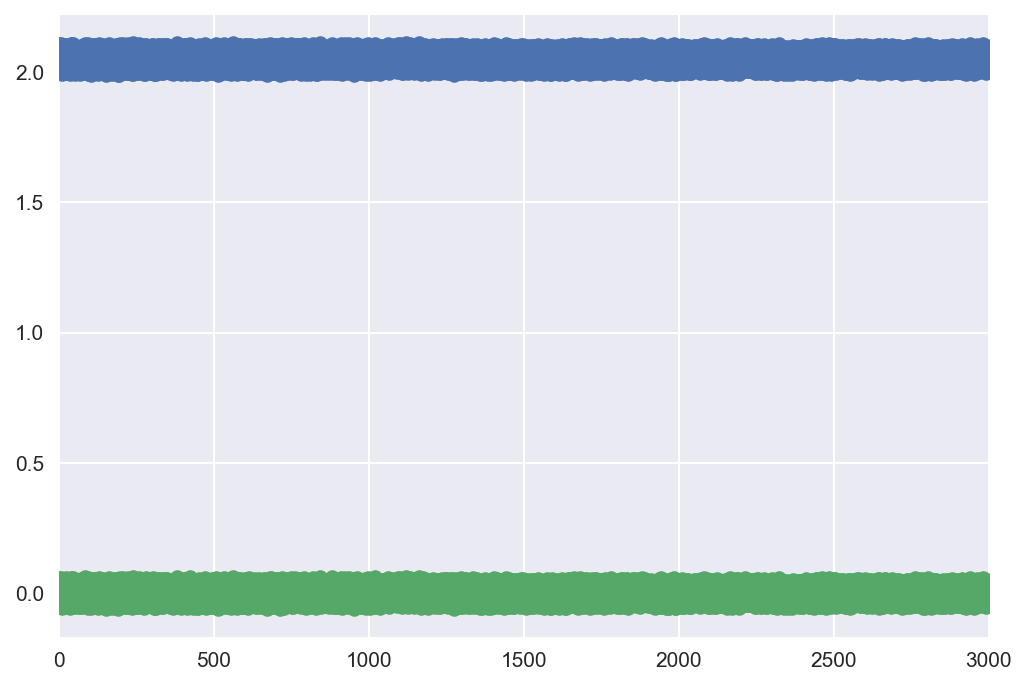

In [14]:
def detrend(x, deg=1):
    A = np.column_stack((np.arange(x.size), np.arange(x.size)**2,np.ones_like(x)))
    y = x.copy()
    x = np.linspace(0, 1, y.size)
    p = np.polyfit(x, y,deg=deg)
    print(p)
    res = y-np.polyval(p, x)
    return res
#plt.plot(pd2[:], 'o-')
plt.plot(pd2[:], 'o-')
plt.plot(detrend(pd2)[:], 'o-')
plt.xlim(0, 3000)

[-0.01794433  1.72581299]
[ 0.01101945  1.04961627]


(0, 3000)

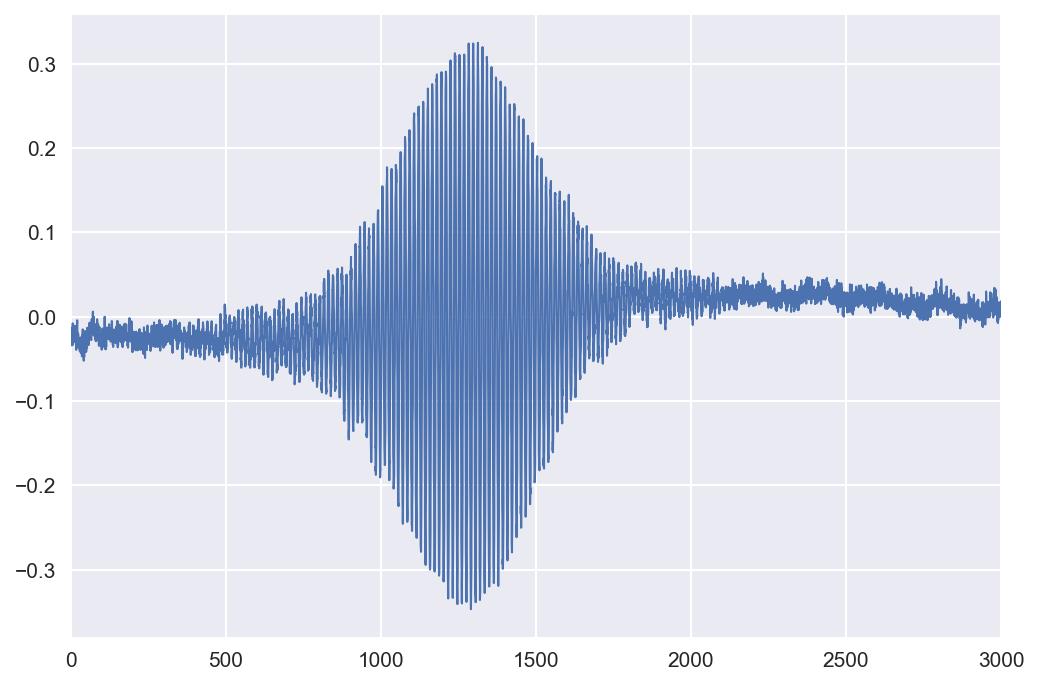

In [28]:
for i in range(1):
    a = np.load('../test_daten//bla_%d.npy'%i)
    pd1, pd2, pyro = a[:, -3:].T
    pd1 = detrend(pd1)
    pd1_state =  (pd1 - pd1.mean()) > 0
    pd2_state =  (pd2 - pd2.mean()) > 0
    counts = np.hstack((0, np.diff(pd1_state).cumsum())) + np.hstack((0, np.diff(pd2_state).cumsum()))
    tau = counts * HeNe_period_fs/4.
    #plt.plot(tau, pyro**2, lw=1)
    plt.plot(tau, detrend(pyro), '-', lw=1)
    #plt.xlim(1200, 1700)
    #plt.figure()
    #plt.plot(tau)
a.shape
plt.xlim(0, 3000)

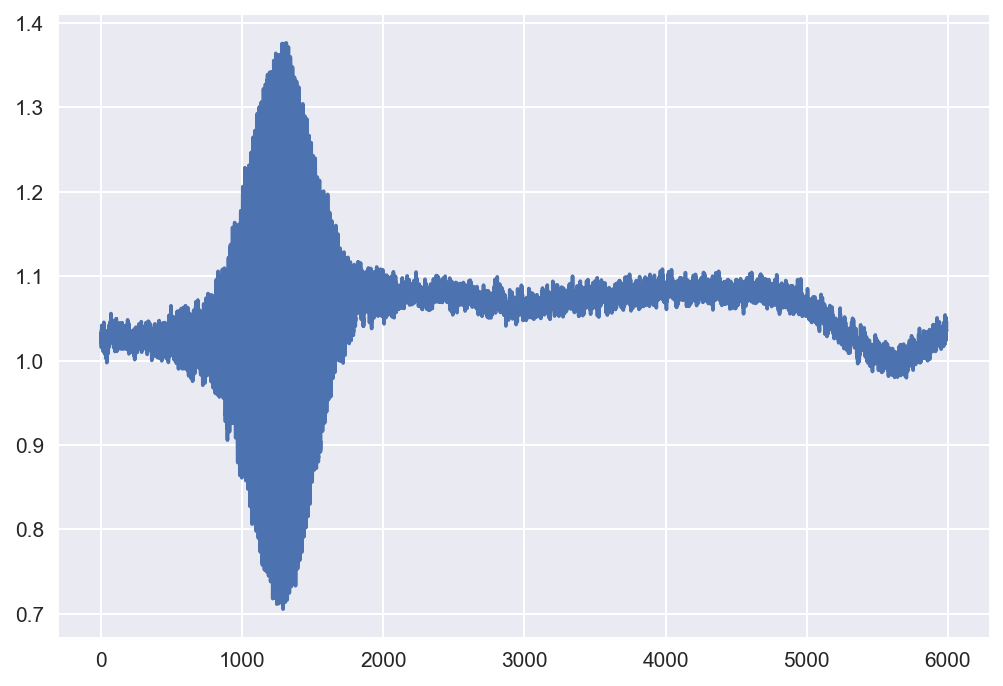

In [10]:
x = np.arange(pd1.size)
plt.plot(tau, pyro)
import scipy.signal
#plt.plot(pd1-pd1.mean())

In [11]:
from scipy.stats import binned_statistic
out, o2, o3, o4 = [], [], [], []
debug = False
for i in range(50):
    a = np.load('../test_daten//bla33_%d.npy'%i)[:, :]
    pd1, pd2, pyro = a[:, -3:].T
    pd1 = detrend(pd1)
    pd1_state =  (pd1 - pd1.mean()) > 0    
    pd2_state =  (pd2 - pd2.mean()) > 0
    pyro = detrend(pyro)
    counts = np.hstack((0, np.diff(pd1_state).cumsum())) + np.hstack((0, np.diff(pd2_state).cumsum()))
    tau = counts * HeNe_period_fs/4.
    step= HeNe_period_fs/2.
    pre_bins = np.arange(0, tau.max(), step)
    m, _, _ = binned_statistic(tau, pyro, 'mean', bins=pre_bins)
    m -= m.mean()
    binned_probe = binned_statistic(tau, a[:, :16].T,
                                    'mean', bins=pre_bins)[0]
    k0, const_phase = phase_ifg(m[:], step=step, j=1)
    
    #k0 = -1500 + k0
    N = int(6000/step)
    #print(N, tau, tau[-k0])
    print(k0,const_phase)
    fr = np.fft.fftfreq(N, step)*1e15
    wn = (fr/speed_of_light)/1e2

    fr2 = np.fft.fftfreq(2*N, step)*1e15
    wn2 = (fr2/speed_of_light)/1e2
    wn2 = np.fft.fftshift(wn2)
    after = True
    window = np.fft.fftshift(np.hanning(N))
    window[N//2:] = 0
    if after:
        ro = lambda a: np.roll(a, k0)
        ctau = np.roll(pre_bins[:-1], k0)[:N]-pre_bins[-k0]
        
        inferferogram = np.roll(m, k0)[:N]
        #inferferogram *= window
        #a, b = phase_correction(inferferogram, step=step, j=3)
        plt.plot(ctau, inferferogram, alpha=0.2, c='r')
        #plt.plot(ctau, window)
        #inferferogram = np.roll(inferferogram, a)
        #plt.plot(ctau, inferferogram, alpha=0.2, c='k')
        #print(phase_correction(inferferogram, step=step, j=3))
        plt.xlim(0, 300)
        binned_probe = np.roll(binned_probe, k0, 1)[:, :N]
        #binned_probe *= window
        
        
        
    else:
        ro = lambda a: np.roll(a, k0)
        k0 = -k0
        #tau = np.roll(pre_bins[:-1], k0)[:N]-pre_bins[-k0]
        ctau = pre_bins[:-1]-pre_bins[k0]
        ctau = ctau[:N]
        index = np.arange(m.size)
        m[index<k0] = 0
        inferferogram = m[:N]
        print(inferferogram.shape)
        #a, b = phase_correction(inferferogram, step=step, j=3)
        plt.plot(ctau, inferferogram, alpha=0.2, c='r')
        #inferferogram = np.roll(inferferogram, a)
        #plt.plot(ctau, inferferogram, alpha=0.2, c='k')
        #print(phase_correction(inferferogram, step=step, j=3))
        plt.xlim(0, 1050)
        binned_probe[:, idx] = 0
        binned_probe = binned_probe[:, :N]
        binned_probe *= window

        
    binned_probe[:, 0] *= 0.5
    #bf = np.fft.fft(np.concatenate((binned_probe, binned_probe[:, ::1]*0)), axis=1)
    bf = np.fft.fft(binned_probe)
    bf /= bf[:, 0, None]
    bf = bf*np.exp(-1j*const_phase)
    o3.append(bf)

    o4.append(const_phase)
    out.append(inferferogram)
    o2.append(binned_probe)

[-0.02593005  1.73465052]
[-0.09915437  1.17438909]


NameError: name 'phase_ifg' is not defined

In [8]:
plt.rcParams['figure.dpi'] = 150
from scipy.stats import trim_mean
inferferogram = np.array(out)
print(inferferogram.shape)
spec = np.fft.fft(inferferogram, axis=1).mean(0)
pr = trim_mean(np.array(o2), 0.00)
pr2 = trim_mean(np.array(o3), 0.05)
#m, const = phase_ifg(inferferogram.mean(0), step)
spec2 = inferferogram.mean(0)
print(const, m, ctau[180])

plt.plot(ctau, inferferogram.mean(0))

plt.xlim(-100, 1000)

plt.figure()
idx = (wn>2200)&(wn<2350)
idx2 = (wn2>2200)&(wn2<2350)
#spec = np.fft.fft(inferferogram)
#plt.plot(spec)
plt.plot(wn[idx], abs(spec[idx]),'b')
plt.plot(wn[idx], abs(spec2[idx]),'r')
plt.twinx()
plt.plot(wn[idx], np.unwrap(np.angle(spec[idx])))
bf = np.fft.fft(pr, axis=1)
bf = bf/bf[:, 0:1]
#bf = np.fft.fftshift(bf, -1)
sig = (bf*np.exp(-1j*const)).real[:, idx]/abs(spec2[idx])
#mi = abs(spec[idx]).min()
sig2 = pr2.real[:, idx]/(abs(spec[idx]))
msig = abs(sig).max()
msig2 = abs(sig2).max()
#plt.figure()
#

#plt.contourf(np.arange(16),wn[idx], sig.T, 15, cmap='bwr', vmin=-msig, vmax=msig)
plt.figure()
plt.contourf(np.arange(16),wn[idx],sig2.T, 25, cmap='bwr', vmin=-msig2, vmax=msig2)
plt.contour(np.arange(16),wn[idx], sig2.T, 25,
            colors='k', linewidths=0.3, linestyles='solid', alpha=1, antialaised=True)
#plt.imshow(sig2.T, cmap='bwr', 
#           interpolation='bilinear', vmin=-msig, vmax=msig, origin='lower',
#           extent=(wn[idx].min(), wn[idx].max(), 16, 0), aspect='auto')
plt.xlabel('Probe freq.')
plt.ylabel('Pump freq.')
plt.grid(0)

NameError: name 'out' is not defined

In [ ]:
phase_ifg(m, step=step)

In [ ]:
def phase_ifg(mr, step, j=3):
    #mr = np.hstack((mr, np.zeros_like(mr)))
    mr_spec = np.fft.fft(mr, mr.size)[:mr.size//2]
    fr = np.fft.fftfreq(mr_spec.size*2, step)*1e15
    wn = (fr/speed_of_light)/1e2
    wk  = wn[:mr.size//2]
    mr_absspec = np.abs(mr_spec)
    pp = np.argmax(mr_absspec[50:])+50
    sl = slice(pp-10, pp+10)
    idx = mr_absspec[sl] > mr_absspec[pp]/2.
    
    mr_phase = np.unwrap(np.angle(mr_spec[sl][idx]))
    #mr_phase = np.angle(mr_spec)
    deriv, const = np.polyfit(wk[sl][idx]-wk[pp], mr_phase, deg=1)[-2:]
    delta_t_fs = deriv/(2*np.pi*speed_of_light*1e-13)
    delta_t_step = int(round(delta_t_fs/step))
    shift_phase = mr_phase.mean()-(delta_t_step*step)/(1/wk[pp]/(speed_of_light*1e-13))
    mr2_spec = np.fft.fft(np.roll(mr, delta_t_step))
    mr_phase = np.unwrap(np.angle(mr2_spec[sl][idx]))
    #shift_phase_m =  -(( -shift_phase + np.pi) % (2.0 * np.pi ) - np.pi)
    #print(round(delta_t_fs/step), shift_phase, mr_phase.mean())
    
    return int(delta_t_step), mr_phase.mean()
binned_pyro = m.copy()/m.max()
m_argmax = np.argmax(abs(binned_pyro)[10:])

mr = np.roll(binned_pyro, 0)
phase_ifg(mr, step=step)

In [ ]:
debug = False


def calc_deriv_phase(mr, ratio, step):
    mr_spec = np.fft.fft(mr, mr.size)[:mr.size//2]
    fr = np.fft.fftfreq(mr_spec.size*2, step)*1e15
    wn = (fr/speed_of_light)/1e2
    wk  = wn[:mr.size//2]
    mr_absspec = np.abs(mr_spec)
    pp = np.argmax(mr_absspec[50:])+50
    sl = slice(pp-20, pp+20)
    idx = mr_absspec[sl] > mr_absspec[pp]*ratio
    mr_phase = np.unwrap(np.angle(mr_spec[sl][idx]))
    if debug:
        plt.figure()
        plt.plot(wk[sl], mr_absspec[sl])    
        plt.twinx()
        plt.plot(wk[sl], np.unwrap(np.angle(mr_spec[sl])), '-or')
        plt.plot(wk[sl][idx], np.unwrap(np.angle(mr_spec[sl]))[idx], '-ok')
    deriv, const = np.polyfit(wk[sl][idx]-wk[pp], mr_phase, deg=1)[-2:]
    return deriv, const


def phase_ifg(mr, step, j=3, ratio=0.6):
    debug = False
    #mr = np.hstack((mr, np.zeros_like(mr)))
    deriv, const = calc_deriv_phase(mr, ratio=ratio, step=step)
    #mr_phase = np.angle(mr_spec)

    #print(wk[sl][idx]-wk[pp])
  
    delta_t_fs = deriv/(2*np.pi*speed_of_light*1e-13)
    delta_t_step1 = int(round(delta_t_fs/step))
    
    #shift_phase = mr_phase.mean()-(delta_t_step1*step)/(1/wk[sl]/(speed_of_light*1e-13))    
    deriv, const = calc_deriv_phase(np.roll(mr, -delta_t_step1), ratio=ratio, step=step)
    #shift_phase_m =  -(( -shift_phase + np.pi) % (2.0 * np.pi ) - np.pi)
    #print(round(delta_t_fs/step), shift_phase, mr_phase.mean())
    
    if debug:
        print(delta_t_step1, delta_t_step2, mr2_phase)
        plt.figure()
        plt.plot(wk[sl], mr_absspec[sl])
        plt.twinx()
        plt.plot(wk[sl], np.unwrap(np.angle(mr_spec[sl])), '-or')
        plt.plot(wk[sl], np.unwrap(np.angle(mr3_spec[sl])), '-or')
        
    return int(delta_t_step1), const
binned_pyro = m.copy()/m.max()
m_argmax = np.argmax(abs(binned_pyro)[10:])

 
mr = np.roll(m, -m_argmax*0)

sh, ph = phase_ifg(mr, step=step, ratio=0.1)
o = []
for i in range(-30, 30, 1):
    mr = np.roll(mr, sh-i)
    sh2, ph2 =calc_deriv_phase(mr, ratio=0.1, step=step)
    o.append((sh-i, sh2, ph2))
print(sh, ph)
o = np.array(o)

plt.plot(o[:, 0], o[:, 1])
plt.plot(o[:, 0], o[:, 2])
#sh, ph = phase_ifg(np.roll(mr, sh+sh1), step=step)

In [ ]:
for i in range(-515,-500 , 1):
    mr = np.roll(m, i)
    #plt.plot(np.diff(mr))
    import scipy.stats as st
    #plt.figure()
    #plt.plot(abs(fft(np.diff(mr)))/140*3)
    plt.plot(np.unwrap(np.angle(fft(np.diff(mr))))[150:230])
    #plt.xlim(200, 230)
    
    #phase_ifg(np.diff(mr), step=step)

In [ ]:
mr = np.roll(binned_pyro, a)
fr = np.fft.fftfreq(mr.size, step)*1e15
wn = (fr/speed_of_light)/1e2
const, deriv = phase_ifg(mr, wn)
mr_spec = np.fft.fft(mr)
wk  = wn[:mr.size//2]
mr_absspec = np.abs(mr_spec)
plt.plot(mr)
plt.figure()
plt.plot(wn, abs(mr_spec))
plt.twinx()
plt.plot(wn, np.angle(mr_spec), '-or')
plt.axhline(const, 0.3, 0.7)
plt.ylim(-3, 3)
plt.xlim(2200, 2400)
np.diff(wn)

In [ ]:
(0.0025/2 * 0.0005)/speed_of_light*1e15
-9+15

In [ ]:
from numpy.fft import fft, ifft, fftshift

from scipy.stats import binned_statistic
out, o2, o3 = [], [], []
for i in range(3):
    a = np.load('../test_daten//bla33_%d.npy'%i)[:, :]
    pd1, pd2, pyro = a[:, -3:].T
    pd1 = detrend(pd1)    
    pd2_state =  (pd2 - pd2.mean()) > 0
    counts = np.hstack((0, np.diff(pd1_state).cumsum())) + np.hstack((0, np.diff(pd2_state).cumsum()))
    tau = counts * HeNe_period_fs/4.
    step= 5 #HeNe_period_fs
    pre_bins = np.arange(0, tau.max(), step)
    m, _, _ = binned_statistic(tau, pyro, 'mean', bins=pre_bins)
    #m -= m.mean()
    #m /= np.abs(m).max()
    #m *= np.hamming(m.size)
    plt.plot(m)
    a, ph = phase_ifg(m[:600]-m[:600].mean(), step=step)    
    print(a, ph)
    mm = ifft(fft(m[-a:]*np.exp(-1j*-ph)))
    out.append(m[-a:])
    o2.append(mm)

In [ ]:
plt.xlim(0, 100)
plt.plot(out[0])
plt.plot(out[1][:])
plt.figure()
plt.plot(o2[0][:])
plt.plot(o2[1][0:])
plt.xlim(0, 100)

In [ ]:
l = [pathlib.Path(i) for i in l]
l

In [ ]:
a = l[0]
l
l[0].name

In [ ]:
fnamelist = [i.name for i in l] 
k = re.search('(\S+)_(\d+)_', fnamelist[3])

In [14]:
fnamelist[3].split('_')
c = l[0]
str(c)

NameError: name 'fnamelist' is not defined

In [15]:
import attr
import glob
import pathlib

l = set(glob.glob('D:/2D Data/bla33_*')) - set(glob.glob('D:/2D Data/r*'))
l = set(glob.glob('D:/test_daten/r*'))
l = [pathlib.Path(i) for i in l]
@attr.s
class ScanFile:
    fname = attr.ib()
    name = attr.ib('')
    scan = attr.ib(0)
    popdelay = attr.ib(0)    
    interleave = attr.ib(0)
    
    def __attrs_post_init__(self):
        print(self.fname)
        l = self.fname.name.split('_')
        pd = l.index('popdelay')
        self.name = l[:pd]
        self.scan = int(l[pd-1])
        self.popdelay = float(l[pd+1])
        self.interleave = float(l[pd+2][:-4])
        self.data = np.load(str(self.fname))

fl = [ScanFile(fname=i) for i in l[:]]
fl

[]

In [16]:
from numpy.fft import fft, ifft, fftfreq
j = [i for i in fl if i.scan==2 and i.popdelay==200]
out, o2, o3 = [], [], []
debug = False
a = np.zeros_like(fl[0].data)
for k,i in enumerate(j[:]):    
    a = i.data
    
    #a /= 3.

    pd1, pd2, pyro = a[:, -3:].T

    pd1_state =  (pd1 - pd1.mean()) > 0
    pd2_state =  (pd2 - pd2.mean()) > 0
    counts = 1*np.hstack((0, np.diff(pd1_state).cumsum())) + 1*np.hstack((0, np.diff(pd2_state).cumsum()))
    tau = counts * HeNe_period_fs/4.
    step= HeNe_period_fs/2.
    N = int(2000/step)

    pre_bins = np.arange(0, tau.max(), step)
    m, _, _ = binned_statistic(tau, pyro, 'mean', bins=pre_bins)
    kpos = np.argmax(m)
    window = np.roll(np.hamming(m.size), -kpos)


    m = detrend(m, 20)
    #m *= window

    #m -= m.mean()
    m /= np.abs(m).max()
    #m *= np.hamming(m.size)
    plt.figure(1)
    p = plt.plot(pre_bins[:-1], m+k)[0]
    sh, ph = phase_ifg(m[:], step=step, ratio=0.1)   
    plt.xlim(0, 1500)
    plt.axvline(-sh, c=p.get_color())
    print(sh, ph)
    #mm = ifft(fft(m[:-i]*np.exp(-1j*-ph)))
    out.append(m[-sh:][:N])
    #o2.append(mm)
    plt.figure(2)
    plt.plot( out[-1])
    #plt.xlim(0, 350)
    plt.figure(3)

    fr = np.fft.fftfreq(int(N), step*1e-15)

    wn = (fr / speed_of_light) / 1e2
    idx = wn> 0
    fr2 = np.fft.fftfreq(int(N)*2, step*1e-15)
    wn2 = (fr2 / speed_of_light) / 1e2
    spec = np.abs(fft(out[-1], N))
    spec2 =   np.abs(fft(out[-1], 2*N))
    plt.plot(wn2, spec2)
    #plt.plot(wn2,  np.angle(fft(out[-1], 2*N)))
    plt.xlim(2100, 2400)
    plt.figure(4)

    #bf = np.fft.fft(np.concatenate((binned_probe, binned_probe[:, ::1]*0)), axis=1)
    binned_probe, _, _ = binned_statistic(tau, (a[:,:16]/a[:,16:32]).T,  'mean', bins=pre_bins)
    #print(binned_probe.shape)
    binned_probe = binned_probe[:, -sh:][:, ::][:, :N]#-binned_probe.mean(1, keepdims=1)

    #binned_probe[:, 0] *= 0.5
    window = np.roll(np.hanning(N*2), -N)
    #binned_probe *= window[:N]
    plt.plot(binned_probe[8, :])
    plt.plot(window[:])
    #bf = np.column_stack((binned_probe-binned_probe.mean(), (binned_probe-binned_probe.mean())[:, ::-1]))
    bf = binned_probe
    bf = np.fft.fft(bf, axis=-1)


    bf = bf*np.exp(-1j*ph)
    bf /= bf[:, 0, None]
    bf /= spec
    #print(step)
    o3.append(bf.real)
    ix = (wn>2150)&(wn<2310)
    #plt.plot(wn[ix], bf.real[7, ix])    
    #plt.plot(wn[ix], spec[ix])
    #plt.xlim(2200, 2500)
    #plt.ylim(-.1, .1)
    #plt.xlim(0)
    #

IndexError: list index out of range

In [17]:
A = np.array(o3).mean(0)
A = np.delete(A, 11, 0)
print(A.shape)

print(A[ :, ix].shape) 
S = np.abs(A[ :, ix]).max()
plt.contourf(np.arange(15), wn2[ix], A[ :, ix].T, 30,cmap='bwr', vmin=-S, vmax=S)
#plt.ylim(2200, 2300)

()


C:\Users\Tillsten\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\Users\Tillsten\Anaconda3\lib\site-packages\numpy\core\_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NameError: name 'ix' is not defined

In [18]:
o3[2].shape

IndexError: list index out of range

In [19]:
wn

NameError: name 'wn' is not defined

(18800, 19000)

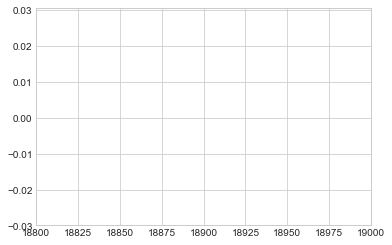

In [20]:
plt.plot(pd1)
plt.xlim(18800, 19000)